## P-NET feedforward network (https://www.nature.com/articles/s41586-021-03922-4)

In [1]:
import time
import os
import torch
import torch_geometric.transforms as T
from torch.utils.data.sampler import SubsetRandomSampler
from torch_geometric.loader import DataLoader
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    auc,
    average_precision_score,
    f1_score,
    accuracy_score,
    precision_score,

    recall_score,
)

from cancernet.arch import PNet
from cancernet.util import ProgressBar, InMemoryLogger, get_roc
from cancernet import PnetDataSet, ReactomeNetwork
from cancernet.dataset import get_layer_maps

/ext3/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## Load Reactome pathways
reactome_kws = dict(
    reactome_base_dir=os.path.join("../data", "reactome"),
    relations_file_name="ReactomePathwaysRelation.txt",
    pathway_names_file_name="ReactomePathways.txt",
    pathway_genes_file_name="ReactomePathways.gmt",
)
reactome = ReactomeNetwork(reactome_kws)

## Initalise dataset
prostate_root = os.path.join("../data", "prostate")
dataset = PnetDataSet(
    root=prostate_root,
    name="prostate_graph_humanbase",
    edge_tol=0.5, ## Gene connectivity threshold to form an edge connection
    pre_transform=T.Compose(
        [T.GCNNorm(add_self_loops=False), T.ToSparseTensor(remove_edge_index=False)]
    ),
)

# loads the train/valid/test split from pnet
splits_root = os.path.join(prostate_root, "splits")
dataset.split_index_by_file(
    train_fp=os.path.join(splits_root, "training_set_0.csv"),
    valid_fp=os.path.join(splits_root, "validation_set.csv"),
    test_fp=os.path.join(splits_root, "test_set.csv"),
)

/ext3/miniconda3/lib/python3.11/site-packages/torch_geometric/data/dataset.py:214: UserWarning: The `pre_transform` argument differs from the one used in the pre-processed version of this dataset. If you want to make use of another pre-processing technique, make sure to delete '../data/prostate' first
  warnings.warn(
/ext3/miniconda3/lib/python3.11/site-packages/torch_geometric/data/in_memory_dataset.py:284: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/ext3/miniconda3/lib/python3.11/site-packages/torch_geometric/data/in_memory_dataset.py:284: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If 

In [3]:
## Get Reactome masks
maps = get_layer_maps(
    genes=[g for g in dataset.node_index],
    reactome=reactome,
    n_levels=6, ## Number of P-NET layers to include
    direction="root_to_leaf",
    add_unk_genes=False,
    verbose=False,
)

pathways 1507
genes 9186
pathways 1397
genes 1515
pathways 1066
genes 1399
pathways 447
genes 1068
pathways 147
genes 448
pathways 26
genes 147
pathways 1
genes 26


## Train

Set up hyperparameters and random seed.

In [4]:
# Set random seed
pl.seed_everything(42, workers=True)

n_epochs = 100
batch_size = 10
lr = 0.001

[rank: 0] Global seed set to 42


Prepare data.

In [5]:
num_workers = 0
train_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(dataset.train_idx),
    num_workers=num_workers,
)
valid_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(dataset.valid_idx),
    num_workers=num_workers,
)

In [6]:
model = PNet(
    layers=maps,
    num_genes=maps[0].shape[0], # 9054
    lr=lr
)

print("Number of params:",sum(p.numel() for p in model.parameters()))
logger = InMemoryLogger()


t0 = time.time()
trainer = pl.Trainer(
    accelerator="auto",
    max_epochs=n_epochs,
    callbacks=[ProgressBar()],
    logger=logger,
    # deterministic=True,
)
trainer.fit(model, train_loader, valid_loader)
print(f"Training took {time.time() - t0:.1f} seconds.")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of params: 74253


You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | criterion         | BCELoss    | 0     
1 | network           | ModuleList | 60.7 K
2 | intermediate_outs | ModuleList | 13.6 K
-------------------------------------------------
74.3 K    Trainable params
0         Non-trainable params
74.3 K    Total params
0.297     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.
/ext3/miniconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The da

Training took 164.5 seconds.


Visualize training trajectory.

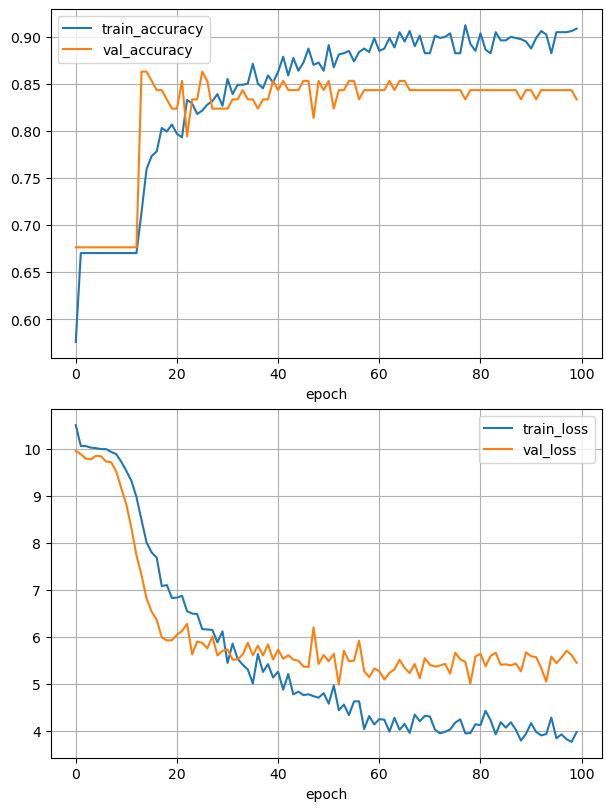

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), constrained_layout=True)
logger.metrics_df.plot("epoch", ["train_accuracy", "val_accuracy"], ax=ax1)
ax1.grid()

logger.metrics_df.plot("epoch", ["train_loss", "val_loss"], ax=ax2)
ax2.grid()

Calculate and show ROC and AUC.

accuracy 0.8333333333333334
auc 0.919631093544137
aupr 0.8752448380672865
f1 0.7536231884057971
precision 0.7222222222222222
recall 0.7878787878787878


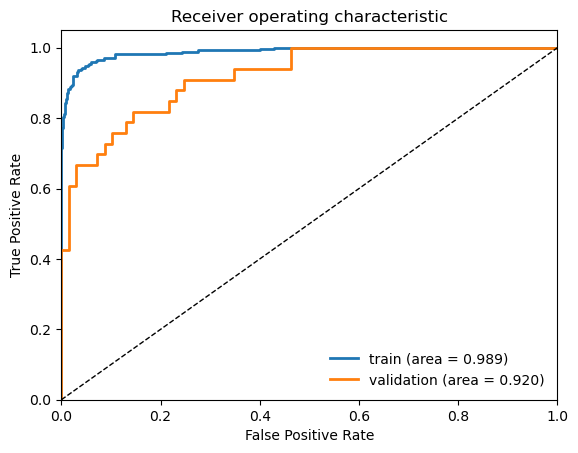

In [8]:
fpr_train, tpr_train, train_auc, _, _ = get_roc(model, train_loader,exp=False)
fpr_valid, tpr_valid, valid_auc, ys, outs = get_roc(model, valid_loader,exp=False)

fig, ax = plt.subplots()
ax.plot(fpr_train, tpr_train, lw=2, label="train (area = %0.3f)" % train_auc)
ax.plot(fpr_valid, tpr_valid, lw=2, label="validation (area = %0.3f)" % valid_auc)
ax.plot([0, 1], [0, 1], color="black", lw=1, linestyle="--")
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("Receiver operating characteristic")
ax.legend(loc="lower right", frameon=False)

print("accuracy", accuracy_score(ys, outs[:, 1] > 0.5))
print("auc", valid_auc)
print("aupr", average_precision_score(ys, outs[:, 1]))
print("f1", f1_score(ys, outs[:, 1] > 0.5))
print("precision", precision_score(ys, outs[:, 1] > 0.5))
print("recall", recall_score(ys, outs[:, 1] > 0.5))

Check performance on test set.

In [9]:
test_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(dataset.test_idx),
    drop_last=True,
)
fpr_test, tpr_test, test_auc, ys, outs = get_roc(model, test_loader,exp=False)

print("accuracy", accuracy_score(ys, outs[:, 1] > 0.5))
print("auc", test_auc)
print("aupr", average_precision_score(ys, outs[:, 1]))
print("f1", f1_score(ys, outs[:, 1] > 0.5))
print("precision", precision_score(ys, outs[:, 1] > 0.5))
print("recall", recall_score(ys, outs[:, 1] > 0.5))

accuracy 0.86
auc 0.9362279511533242
aupr 0.8877462877876023
f1 0.7666666666666667
precision 0.8518518518518519
recall 0.696969696969697
